In [1]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

from analysis import CellGraph, DataReader
from analysis import CurrentTrace

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import correlate
from statsmodels.tsa.arima.model import ARIMA

In [9]:
SIM_DIRECTORY_PREFIX = "../scripts/10sec"
NEXUS_INDEX = 77 # 379
SOMA_INDEX = 0
SIM_TIME = 2000

seeds = [123]

In [10]:
sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(123))
adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
np.where(adj_matrix[77] > 0)[0]

array([78, 82, 86, 90])

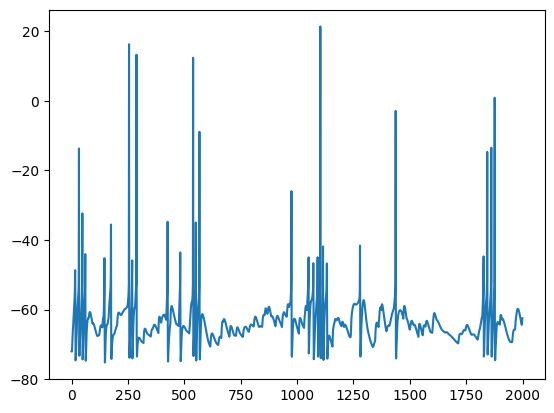

In [24]:
sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(123))
v = DataReader.read_data(sim_directory, "v")
plt.plot(v[0])

In [12]:
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))
ed = pd.read_csv(os.path.join(sim_directory, "elec_distance_soma.csv"))
adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))

In [13]:
apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]
np.min(ed.loc[apical_branches, "beta_passive"])

0.2653917210958145

In [14]:
soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
basal_branches = seg_data.iloc[soma_children]
basal_branches = basal_branches[basal_branches.section == "dend"].index
np.min(ed.loc[basal_branches, "beta_passive"])

0.7429092271471275

## Cross-Correlation Analysis

In [365]:
ccm_nexus = []
ccm_basal = []

for seed in seeds:
    sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

    # Read data
    v = DataReader.read_data(sim_directory, "v")
    adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
    seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

    # Compute axial currents
    ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

    # Find indexes of apical branches (= nexus's children)
    apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]
    
    # Compute correlations between currents
    cross_corr_matrix = np.zeros((len(apical_branches), len(apical_branches), SIM_TIME))
    for i in range(len(apical_branches)):
        for j in range(len(apical_branches)):
            cross_corr_matrix[i, j] = correlate(ac_matrix[NEXUS_INDEX, apical_branches[i]], ac_matrix[NEXUS_INDEX, apical_branches[j]])[SIM_TIME-1:]
    ccm_nexus.append(cross_corr_matrix)

    # Find indexes of soma's children
    soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
    basal_branches = seg_data.iloc[soma_children]
    basal_branches = basal_branches[basal_branches.section == "dend"].index

    cross_corr_matrix = np.zeros((len(basal_branches), len(basal_branches), SIM_TIME))
    for i in range(len(basal_branches)):
        for j in range(len(basal_branches)):
            cross_corr_matrix[i, j] = correlate(ac_matrix[SOMA_INDEX, basal_branches[i]], ac_matrix[SOMA_INDEX, basal_branches[j]])[SIM_TIME-1:]
    ccm_basal.append(cross_corr_matrix)

In [398]:
np.savetxt("ac0.txt", ac_matrix[NEXUS_INDEX, apical_branches[0]])

In [401]:
len(ac_matrix[NEXUS_INDEX, apical_branches[0]])

2000

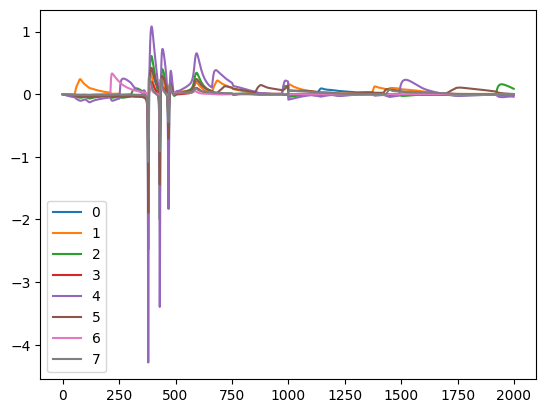

In [367]:
for i in range(len(basal_branches)):
    plt.plot(ac_matrix[SOMA_INDEX, basal_branches[i]], label = str(i))
plt.legend()

In [368]:
ccm_nexus_all = np.stack(ccm_nexus)
np.argmax(np.mean(ccm_nexus_all, axis = 0), axis = -1)

array([[ 0, 28],
       [ 0,  0]])

In [370]:
ccm_soma_all = np.stack(ccm_basal)
np.argmax(np.mean(ccm_soma_all, axis = 0), axis = -1)

array([[0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

## ARIMA Analysis

In [371]:
# https://stats.stackexchange.com/questions/93540/testing-equality-of-coefficients-from-two-different-regressions
Z_nexus = []
Z_basal = []

for seed in seeds:
    sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

    # Read data
    v = DataReader.read_data(sim_directory, "v")
    adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
    seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

    # Compute axial currents
    ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

    # Find indexes of apical branches (= nexus's children)
    apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]
    
    # Estimate ARIMAs between currents
    Z_matrix = np.zeros((len(apical_branches), len(apical_branches), 5))
    for i in range(len(apical_branches)):
        for j in range(len(apical_branches)):
            model1 = ARIMA(ac_matrix[NEXUS_INDEX, apical_branches[i]], order = (2, 0, 2))
            res1 = model1.fit()
            model2 = ARIMA(ac_matrix[NEXUS_INDEX, apical_branches[j]], order = (2, 0, 2))
            res2 = model2.fit()
            Z = (res1.params - res2.params) / np.sqrt(np.diag(res1.cov_params()) + np.diag(res2.cov_params()))
            Z_matrix[i, j] = Z[:-1]
    Z_nexus.append(Z_matrix)

    # Find indexes of soma's children
    soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
    basal_branches = seg_data.iloc[soma_children]
    basal_branches = basal_branches[basal_branches.section == "dend"].index

    Z_matrix = np.zeros((len(basal_branches), len(basal_branches), 5))
    for i in range(len(basal_branches)):
        for j in range(len(basal_branches)):
            model1 = ARIMA(ac_matrix[SOMA_INDEX, basal_branches[i]], order = (2, 0, 2))
            res1 = model1.fit()
            model2 = ARIMA(ac_matrix[SOMA_INDEX, basal_branches[j]], order = (2, 0, 2))
            res2 = model2.fit()
            Z = (res1.params - res2.params) / np.sqrt(np.diag(res1.cov_params()) + np.diag(res2.cov_params()))
            Z_matrix[i, j] = Z[:-1]
    Z_basal.append(Z_matrix)

/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/simulati

In [380]:
Z_nexus_all = np.stack(Z_nexus)
Z_nexus_all_avg = np.mean(Z_nexus_all, axis = 0)
np.sum(np.abs(Z_nexus_all_avg) < 1.96, axis = -1) / 5

array([[1. , 0.2],
       [0.2, 1. ]])

In [381]:
Z_basal_all = np.stack(Z_basal)
Z_basal_all_avg = np.mean(Z_basal_all, axis = 0)
np.sum(np.abs(Z_basal_all_avg) < 1.96, axis = -1) / 5

array([[1. , 1. , 0.4, 1. , 0.4, 0.6, 1. , 0.4],
       [1. , 1. , 1. , 0.8, 0.8, 0.6, 1. , 0.6],
       [0.4, 1. , 1. , 0.6, 1. , 0.4, 1. , 0.8],
       [1. , 0.8, 0.6, 1. , 0.6, 0.6, 1. , 0.6],
       [0.4, 0.8, 1. , 0.6, 1. , 0.4, 1. , 0.8],
       [0.6, 0.6, 0.4, 0.6, 0.4, 1. , 1. , 0.2],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [0.4, 0.6, 0.8, 0.6, 0.8, 0.2, 1. , 1. ]])

## Generating currents based on ARIMA

In [382]:
seed = 123
sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

# Read data
v = DataReader.read_data(sim_directory, "v")
adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

# Compute axial currents
ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

# Find indexes of apical branches (= nexus's children)
apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]

models = []
for i in range(len(apical_branches)):
    model = ARIMA(ac_matrix[NEXUS_INDEX, apical_branches[i]], order = (4, 0, 5))
    models.append(model.fit())

In [388]:
def generate_trace_with_model(model, size):
    np.random.seed(123)
    const = model.params[0]
    ar = model.params[1:5]
    ma = model.params[5:-1]
    sigma = model.params[-1]
    out = [0, -0.        ,  0.03531086,  0.05447467]
    for _ in range(size):
        pred = const + np.sum(ar.T * np.array(out[-4:]))
        out.append(pred)
    return out

In [389]:
print(np.round(models[0].params, 3))
models[0].summary()

[ 0.054  2.889 -3.143  1.588 -0.335 -0.814  0.4   -0.051  0.013  0.005
  0.   ]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(4, 0, 5)   Log Likelihood               12347.925
Date:                Wed, 20 Mar 2024   AIC                         -24673.850
Time:                        15:47:56   BIC                         -24612.240
Sample:                             0   HQIC                        -24651.228
                               - 2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0537      0.001     56.461      0.000       0.052       0.056
ar.L1          2.8893      0.001   2443.583      0.000       2.887       2.892
ar.L2         -3.1426      0.001  -2264.951      0.000      -3.145      -3.140
ar.L3          1.5883      0.003    488.540      0.000       1.582       1.595
ar.L4         -0.3353      0.003   -102.242      0.000      -0.342      -0.329
ma.L1         -0.8136      0.002   -372.722      0.000      -0.818      -0.809
ma.L2          0.4000      0.008     48.337      0.000       0.384       0.416
ma.L3         -0.0506      0.009     -5.370      0.000      -0.069      -0.032
ma.L4          0.0132      0.008      1.572      0.116      -0.003       0.030
ma.L5          0.0046      0.009      0.493      0.622      -0.014       0.023
sigma2      2.524e-07   7.24e-10    348.709      0.000    2.51e-07    2.54e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           8828738.08
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             4.32
Prob(H) (two-sided):                  0.00   Kurtosis:                       328.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.87e+17. Standard errors may be unstable.
"""

/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/gs/_z8_31zd6xz_w20ny978y50w0000gn/T/ipykernel_13120/3988657720.py:9: RuntimeWarning: overflow encountered in multiply
  pred = const + np.sum(ar.T * np.array(out[-4:]))


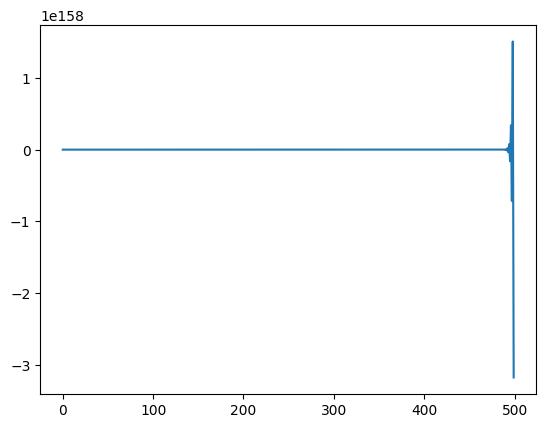

In [392]:
out = generate_trace_with_model(models[0], 2000)
plt.plot(out[:500])

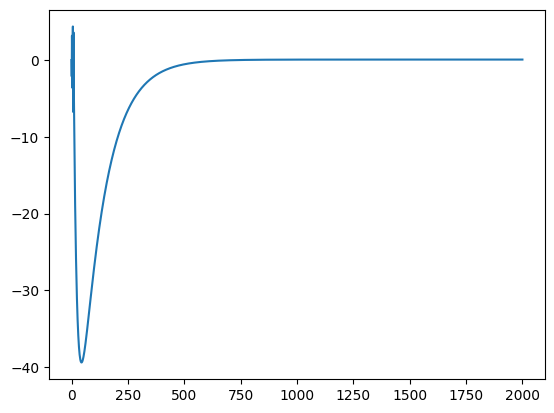

In [386]:
nm = models[0].append(models[0].predict(0, 9) + np.random.normal(0, 1, 10))
plt.plot(nm.predict(2000, 4000))

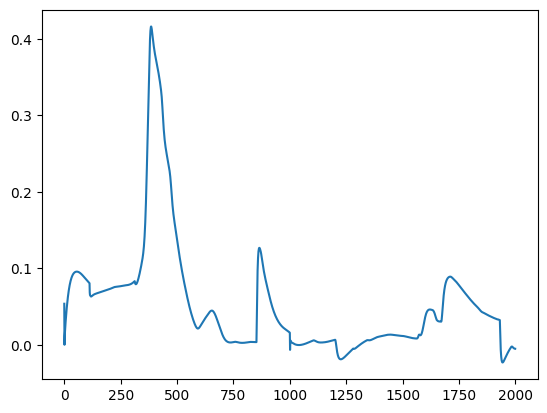

In [387]:
plt.plot(models[0].predict())

380 0.05367143905642357 0.07637665047239821


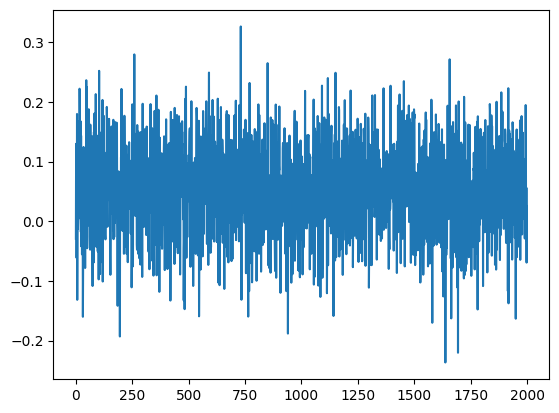

In [395]:
np.random.seed(123)
trace = ac_matrix[NEXUS_INDEX, apical_branches[0]]
plt.plot(np.random.normal(np.mean(trace), np.std(trace), 2000))
print(apical_branches[0], np.mean(trace), np.std(trace))

## (?) Magnitude Analysis

In [97]:
magn_apic = []
magn_apic_trunk = []
magn_basal = []

for seed in seeds:
    sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

    # Read data
    v = DataReader.read_data(sim_directory, "v")
    adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
    seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

    # Compute axial currents
    ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

    # Find indexes of apical branches (= nexus's children)
    apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]
    magn_apic.append(np.abs(ac_matrix[apical_branches]))
    
    # Find indexes of soma's children
    soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
    basal_branches = seg_data.iloc[soma_children]
    basal_branches = basal_branches[basal_branches.section == "dend"].index
    magn_basal.append(np.abs(ac_matrix[basal_branches]))

    apic_trunk = seg_data.iloc[soma_children]
    apic_trunk = apic_trunk[apic_trunk.section == "apic"].index
    magn_apic_trunk.append(np.abs(ac_matrix[apic_trunk]))

In [98]:
magn_apic_all = np.stack(magn_apic)
magn_apic_trunk_all = np.stack(magn_apic_trunk)
magn_basal_all = np.stack(magn_basal)

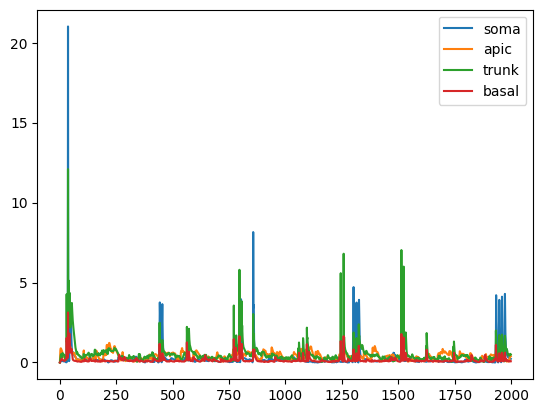

In [115]:
plt.plot(np.abs(ac_matrix[0]), label = 'soma')
plt.plot(np.sum(np.mean(magn_apic_all, axis = 0), axis = 0), label = 'apic')
plt.plot(np.sum(np.mean(magn_apic_trunk_all, axis = 0), axis = 0), label = 'trunk')
plt.plot(np.sum(np.mean(magn_basal_all, axis = 0), axis = 0), label = 'basal')
plt.legend()

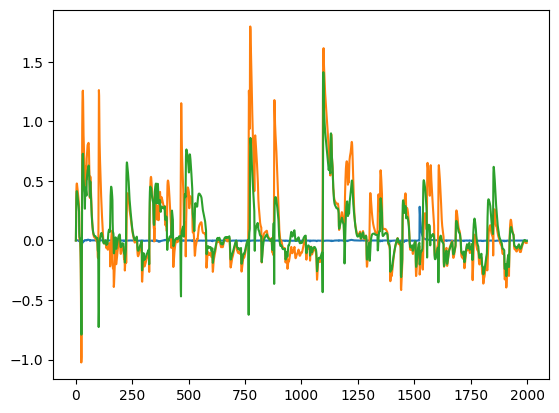

In [53]:
plt.plot(ac_matrix[381])
plt.plot(ac_matrix[393])
plt.plot(ac_matrix[422])

In [53]:
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
from matplotlib import colormaps, colors, cm
import matplotlib.animation as animation

def plot_cell(seg_data, color = None):

    start_coords = seg_data.loc[:, ["p0_0", "p0_1", "p0_2"]].to_numpy()
    center_coords = seg_data.loc[:, ["pc_0", "pc_1", "pc_2"]].to_numpy()
    end_coords = seg_data.loc[:, ["p1_0", "p1_1", "p1_2"]].to_numpy()

    fig = plt.figure(figsize = (20, 20))
    ax = fig.add_subplot(projection = '3d')

    # All these values are heuristics
    ax.view_init(elev = 10, azim = 0)
    ax.grid(False)
    ax.set_axis_off()
    x_scale=1
    y_scale=1
    z_scale=1.5

    scale=np.diag([x_scale, y_scale, z_scale, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=1.0

    from mpl_toolkits.mplot3d.axes3d import Axes3D
    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)

    ax.get_proj=short_proj
    ax.dist = 0.2
    r = Rotation.from_euler('yx', (90, 90), degrees = True)
    start_coords = r.apply(start_coords)
    end_coords = r.apply(end_coords)

    if color is not None:
        cmap = colormaps.get_cmap("Spectral")
        # Normalize because color maps are defined in [0, 1]
        norm = colors.Normalize(np.min(color), np.max(color))
        fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), ax = ax, fraction = 0.026, pad = 0.04)

    for i in range(len(seg_data)):
        ax.plot(
            np.hstack([start_coords[i, 0], end_coords[i, 0]]),
            np.hstack([start_coords[i, 1], end_coords[i, 1]]),
            np.hstack([start_coords[i, 2], end_coords[i, 2]]),
            color = cmap(norm(color[i])) if color is not None else 'teal'
        )
    return fig

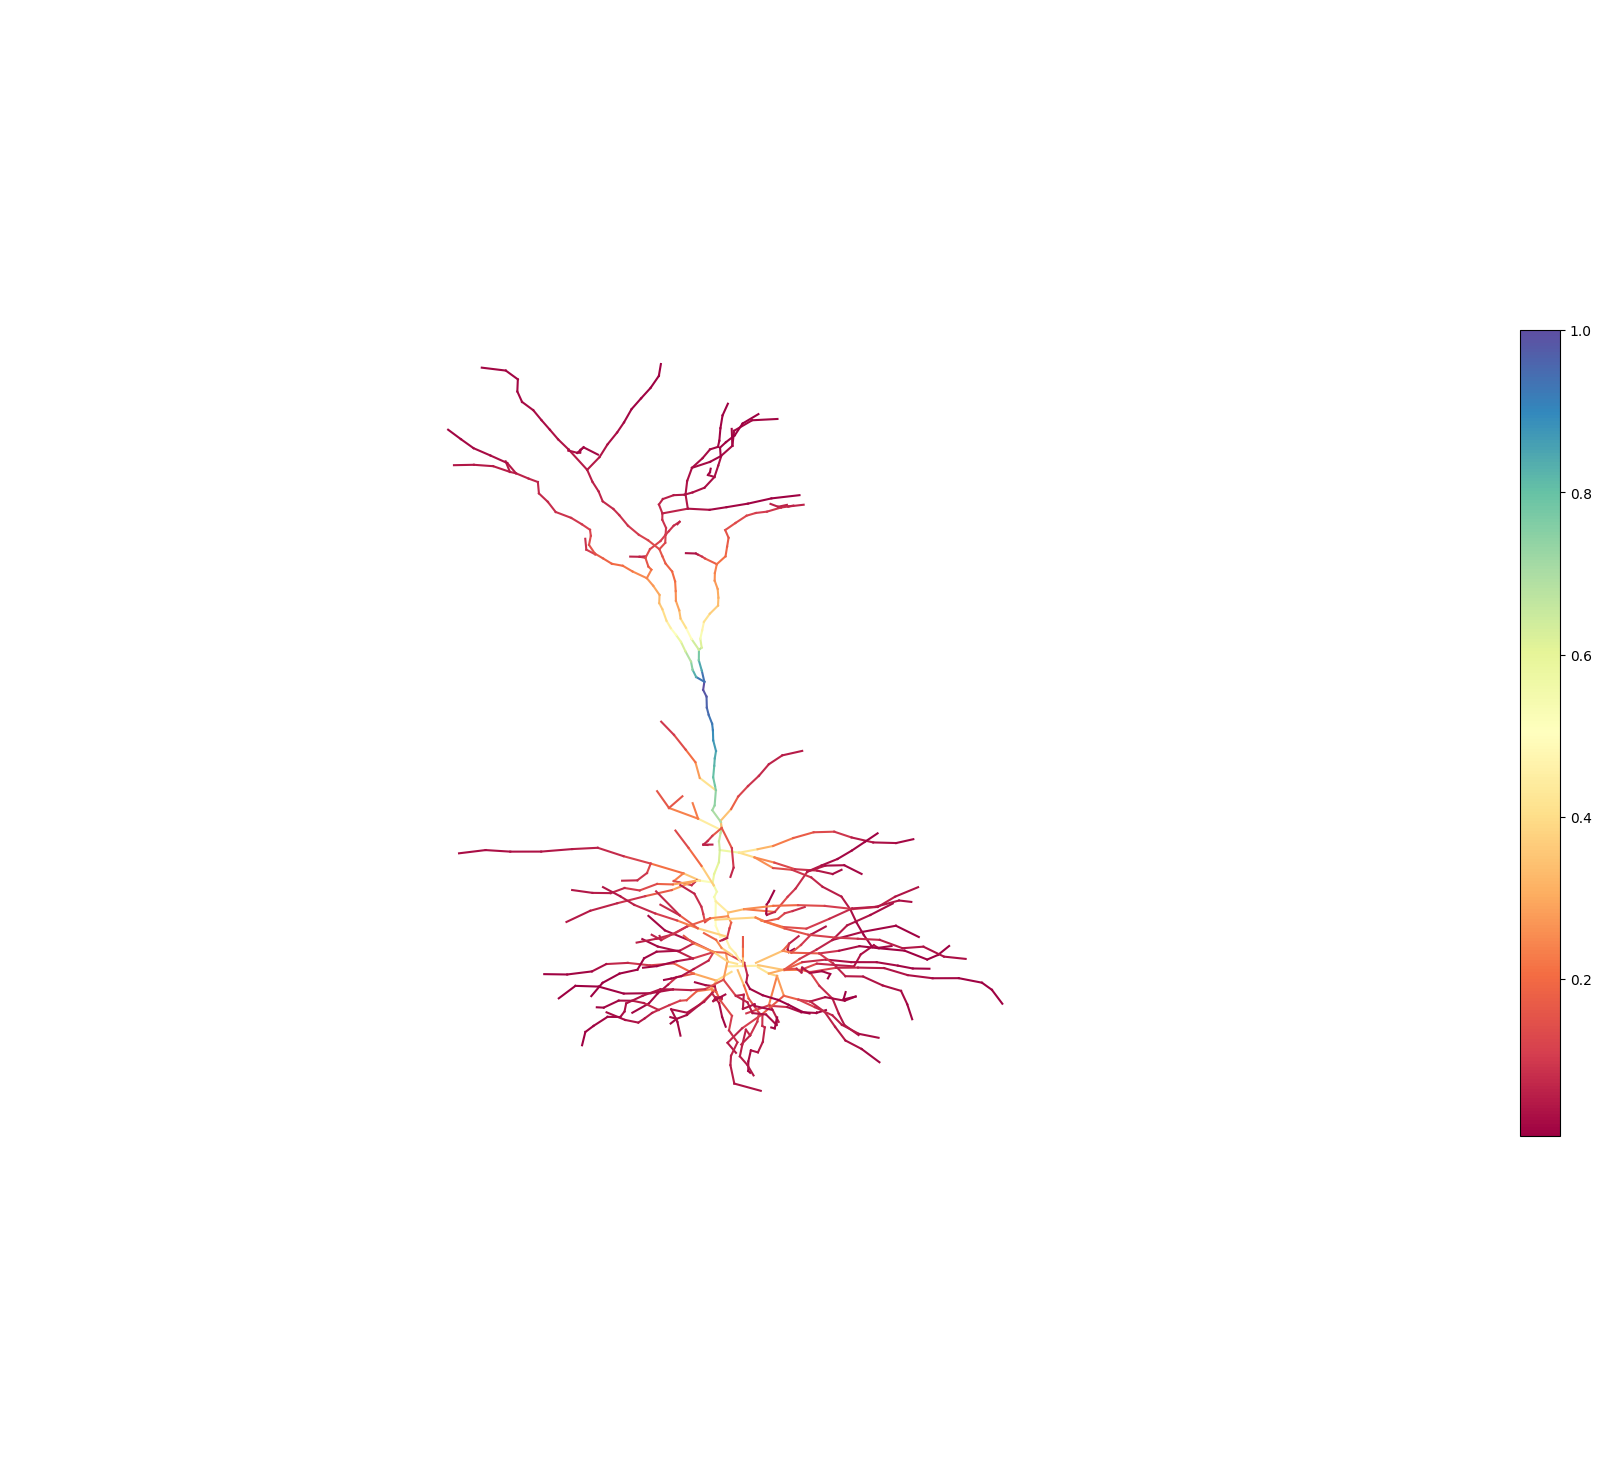

In [54]:
sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(123))
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))
ed = pd.read_csv(os.path.join(sim_directory, "elec_distance_nexus.csv"))

fig = plot_cell(seg_data, color = ed['beta_passive'].to_numpy())

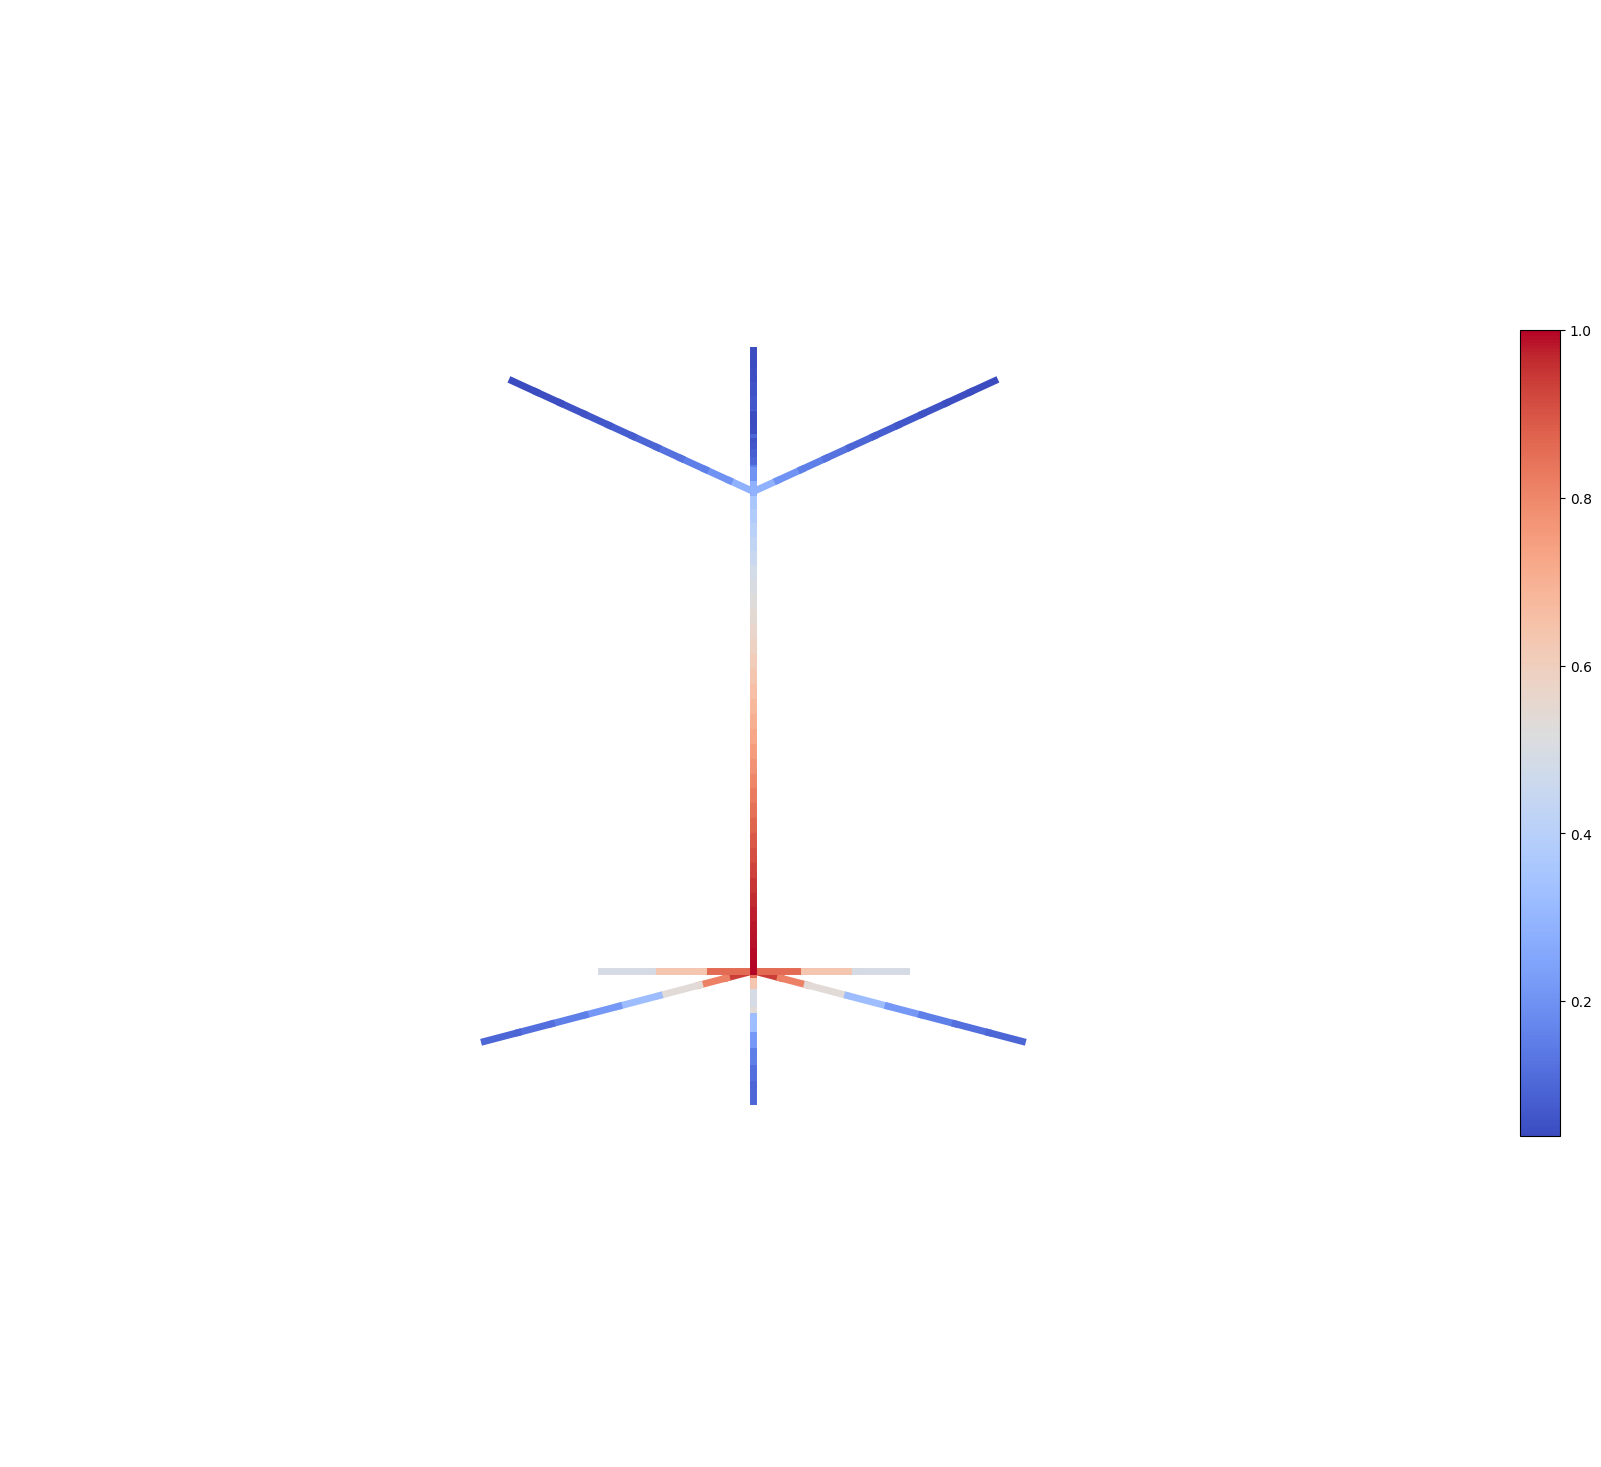

In [11]:
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
from matplotlib import colormaps, colors, cm
import matplotlib.animation as animation

def plot_cell(seg_data, color = None):

    start_coords = seg_data.loc[:, ["p0_0", "p0_1", "p0_2"]].to_numpy()
    center_coords = seg_data.loc[:, ["pc_0", "pc_1", "pc_2"]].to_numpy()
    end_coords = seg_data.loc[:, ["p1_0", "p1_1", "p1_2"]].to_numpy()

    fig = plt.figure(figsize = (20, 20))
    ax = fig.add_subplot(projection = '3d')

    # All these values are heuristics
    ax.view_init(elev = 10, azim = 0)
    ax.grid(False)
    ax.set_axis_off()
    x_scale=1
    y_scale=1
    z_scale=1.5

    scale=np.diag([x_scale, y_scale, z_scale, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=1.0

    from mpl_toolkits.mplot3d.axes3d import Axes3D
    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)

    ax.get_proj=short_proj
    ax.dist = 0.2
    r = Rotation.from_euler('yx', (90, 90), degrees = True)
    start_coords = r.apply(start_coords)
    end_coords = r.apply(end_coords)

    if color is not None:
        cmap = colormaps.get_cmap("coolwarm")
        # Normalize because color maps are defined in [0, 1]
        norm = colors.Normalize(np.min(color), np.max(color))
        fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), ax = ax, fraction = 0.026, pad = 0.04)

    for i in range(len(seg_data)):
        ax.plot(
            np.hstack([start_coords[i, 0], end_coords[i, 0]]),
            np.hstack([start_coords[i, 1], end_coords[i, 1]]),
            np.hstack([start_coords[i, 2], end_coords[i, 2]]),
            color = cmap(norm(color[i])) if color is not None else 'teal',
            linewidth = 5
        )
    return fig

sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(123))
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))
ed = pd.read_csv(os.path.join(sim_directory, "elec_distance_soma.csv"))

fig = plot_cell(seg_data, color = ed['beta_passive'].to_numpy())

In [ ]:
cmap = sns.color_palette("coolwarm", as_cmap = True)

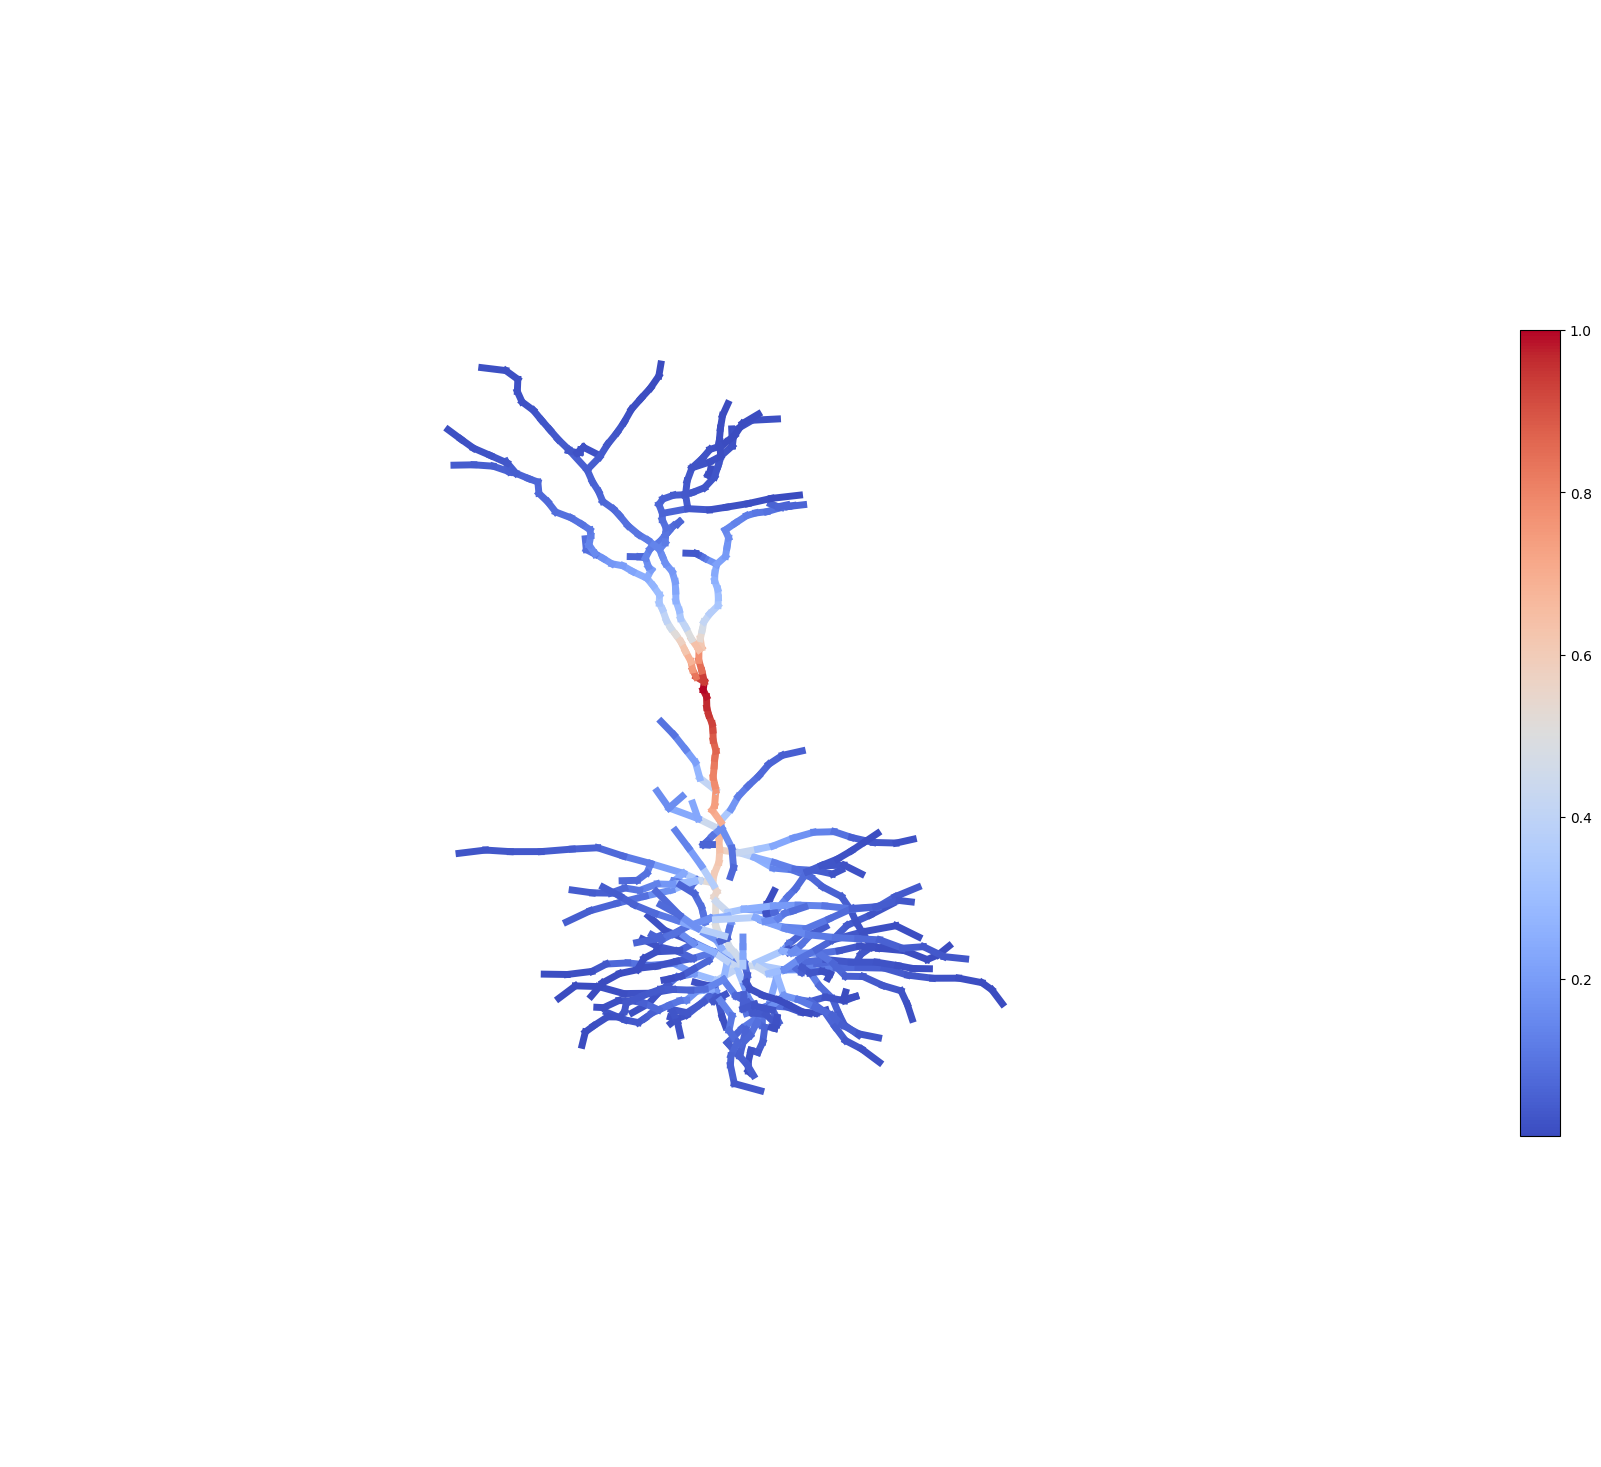

In [6]:
SIM_DIRECTORY_PREFIX = '/Users/vladimiromelyusik/FULL_MODEL/Neural-Modeling/scripts/2000'
sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(123))
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))
ed = pd.read_csv(os.path.join(sim_directory, "elec_distance_nexus.csv"))

fig = plot_cell(seg_data, color = ed['beta_passive'].to_numpy())